### Training of modified U-Net for Optic Disc on RIM-ONE v3 database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/01.03,10:33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import skimage.transform
import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

In [3]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [4]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 2.0.0


In [5]:
K.set_image_data_format('channels_first')

In [6]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [7]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [8]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [9]:
# h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'RIM_ONE_v3.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [10]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [11]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=3e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

/home/artem/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        dropout_1[0][0]                  
____________________________________________________________________________________________

#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

In [13]:
# Loading full images of desired resolution:
X = h5f['RIM-ONE v3/512 px/images']
Y = h5f['RIM-ONE v3/512 px/cup']
disc_locations = h5f['RIM-ONE v3/512 px/disc_locations']

In [14]:
X, Y

(<HDF5 dataset "images": shape (159, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (159, 512, 512, 1), type "|u1">)

In [15]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5, random_state=1).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 12

In [16]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [17]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

#### Generator of augmented data:

In [18]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=(0.8, 1.2),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [106]:
def preprocess(batch_X, batch_y, train_or_test='train'):    
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i])
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, resize_to=128, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_X = [np.rollaxis(img, 2) for img in batch_X]
        batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
                   for img in batch_X]
        batch_X = np.array(batch_X).copy()
        
        batch_y = [y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_y = [img[..., 0] for img in batch_y]
        batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [107]:
gen = data_generator(X, Y, 128, 'train', batch_size=1)
batch = next(gen)
batch[0].shape

(1, 3, 128, 128)

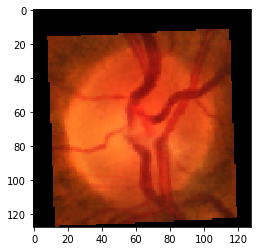

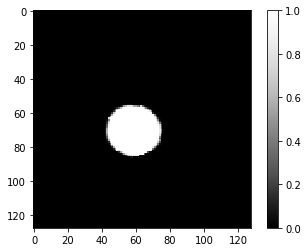

In [108]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [ ]:
arch_name = "OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)

In [110]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

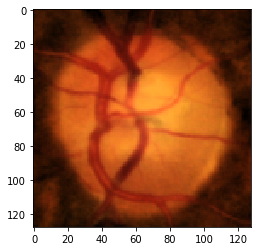

(32, 3, 128, 128) (32, 1, 128, 128)


In [111]:
X_valid, Y_valid = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True))
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              epochs=500, verbose=1,
                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

### Visual check

image #0


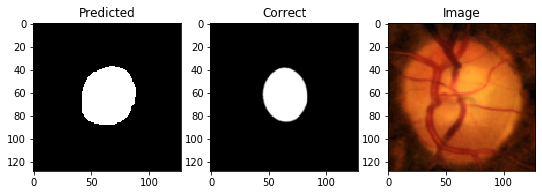

IOU: 0.7119171023368835
Dice: 0.8422696367205645
image #1


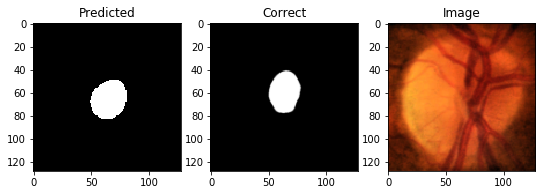

IOU: 0.5821782350540161
Dice: 0.7468749048519422
image #2


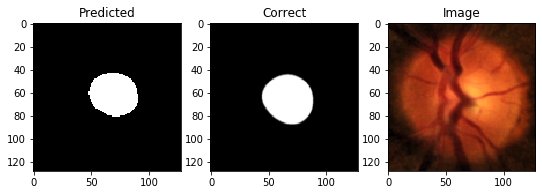

IOU: 0.7324393391609192
Dice: 0.8577079191941486
image #3


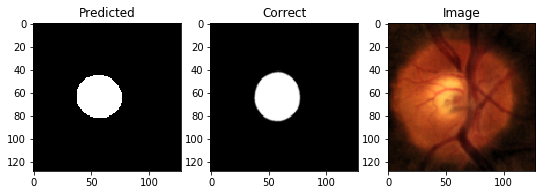

IOU: 0.8581183552742004
Dice: 0.9380771818017486
image #4


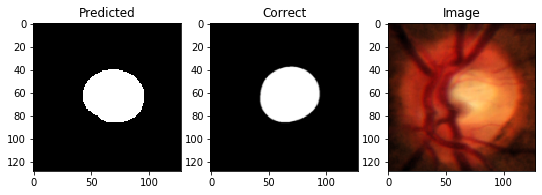

IOU: 0.8776105046272278
Dice: 0.9436350305482908
image #5


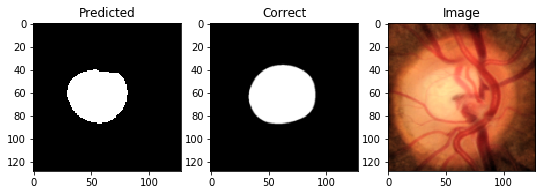

IOU: 0.7101975083351135
Dice: 0.8391966948135371
image #6


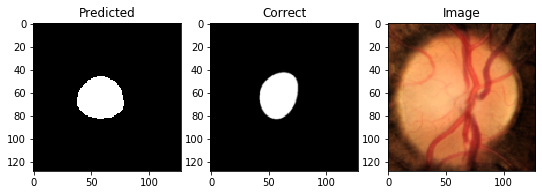

IOU: 0.738959014415741
Dice: 0.8603585190458424
image #7


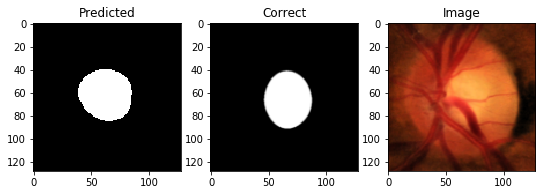

IOU: 0.7100371718406677
Dice: 0.8407840561337373
image #8


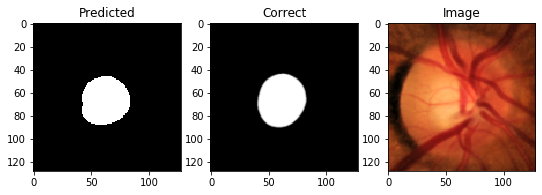

IOU: 0.9005201458930969
Dice: 0.9595170462735056
image #9


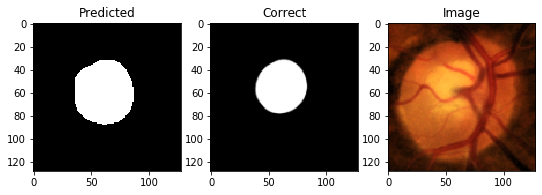

IOU: 0.6840292811393738
Dice: 0.8197249705347944
image #10


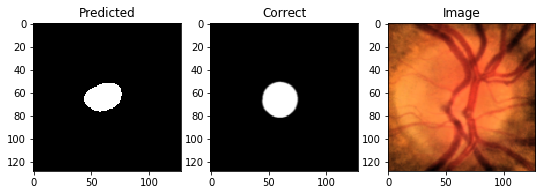

IOU: 0.7299741506576538
Dice: 0.8633391817872305
image #11


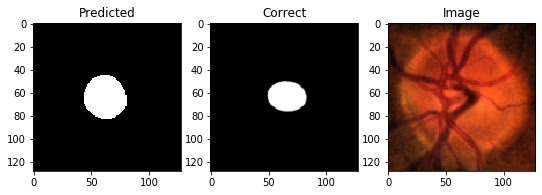

IOU: 0.5735682845115662
Dice: 0.7400136231686569
image #12


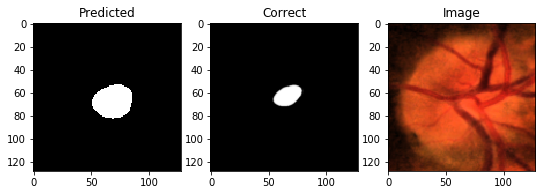

IOU: 0.3955223858356476
Dice: 0.5753085890097761
image #13


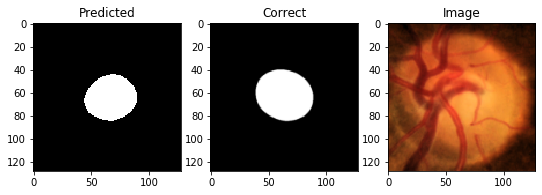

IOU: 0.7982708811759949
Dice: 0.8949567102303034
image #14


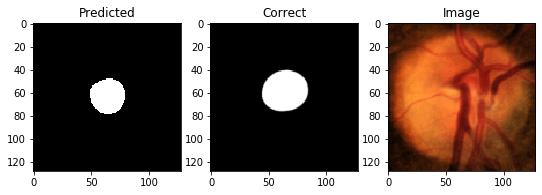

IOU: 0.6044905185699463
Dice: 0.7666318623647891
image #15


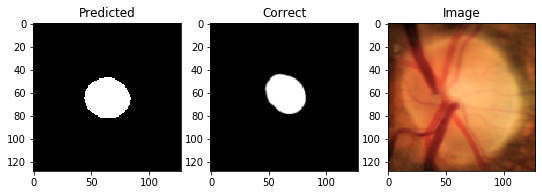

IOU: 0.7189939022064209
Dice: 0.848629153055031
image #16


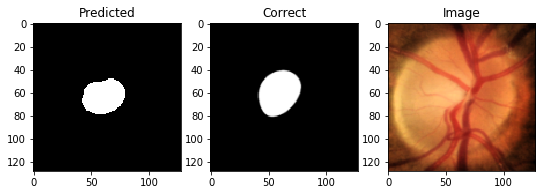

IOU: 0.6999147534370422
Dice: 0.8387469822911091
image #17


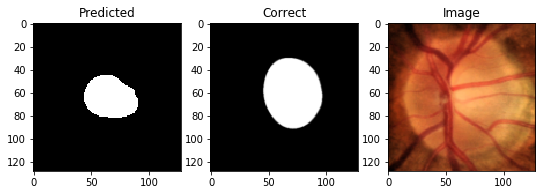

IOU: 0.5249695777893066
Dice: 0.6970783061602241
image #18


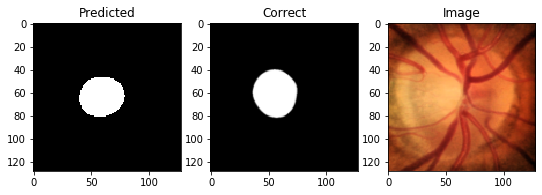

IOU: 0.7399545311927795
Dice: 0.8606505379113841
image #19


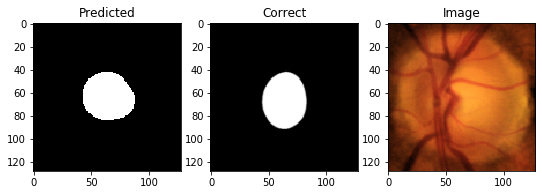

IOU: 0.756083071231842
Dice: 0.8731441026235571
image #20


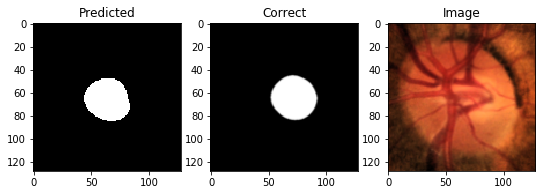

IOU: 0.573479175567627
Dice: 0.741461685906716
image #21


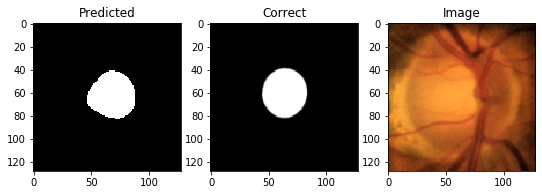

IOU: 0.7491571307182312
Dice: 0.8678364514418063
image #22


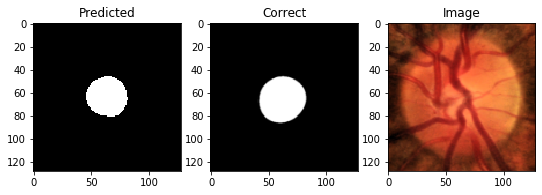

IOU: 0.7657728791236877
Dice: 0.8783981574819603
image #23


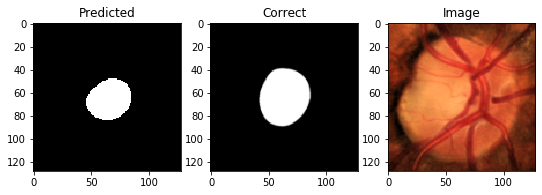

IOU: 0.6304093599319458
Dice: 0.7855174884855098
image #24


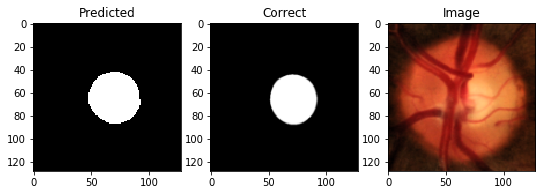

IOU: 0.8477029800415039
Dice: 0.9262092988238971
image #25


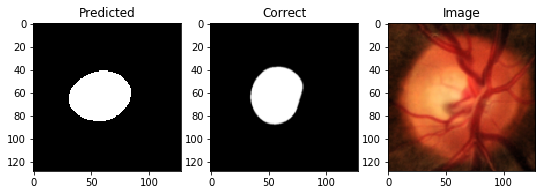

IOU: 0.8029606938362122
Dice: 0.9017487269685035
image #26


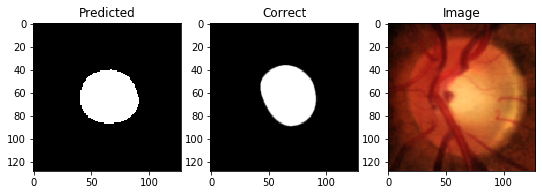

IOU: 0.8133333325386047
Dice: 0.9068666308582871
image #27


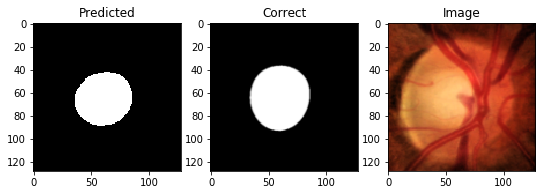

IOU: 0.8032427430152893
Dice: 0.9019114553997796
image #28


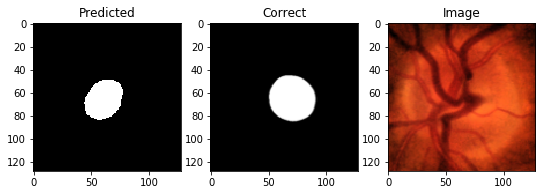

IOU: 0.4744827449321747
Dice: 0.6565118194555722
image #29


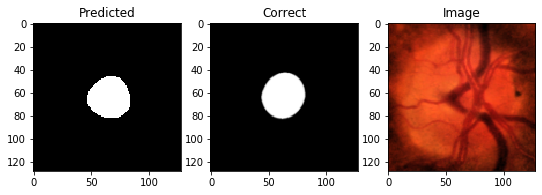

IOU: 0.7862969040870667
Dice: 0.8936452188757924
image #30


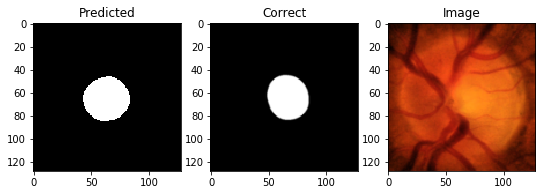

IOU: 0.761432945728302
Dice: 0.8765453381613517
image #31


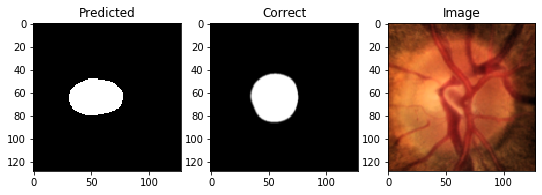

IOU: 0.7275204062461853
Dice: 0.8552942699280571


In [118]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

image #0


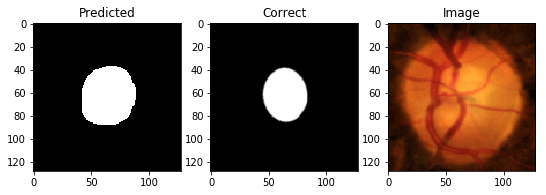

IOU: 0.693239152431
Dice: 0.830236199302
image #1


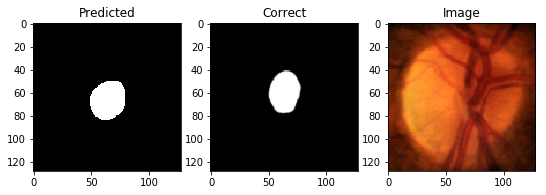

IOU: 0.570029377937
Dice: 0.736633356306
image #2


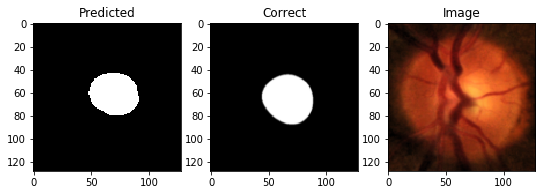

IOU: 0.7130215168
Dice: 0.843655052639
image #3


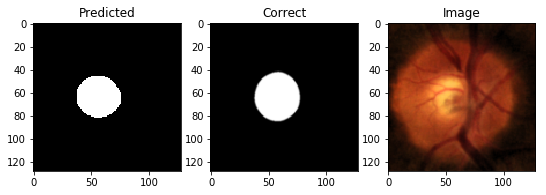

IOU: 0.812785387039
Dice: 0.911701504219
image #4


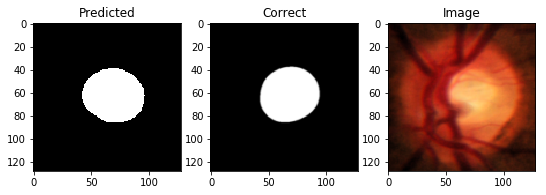

IOU: 0.891293883324
Dice: 0.951246905722
image #5


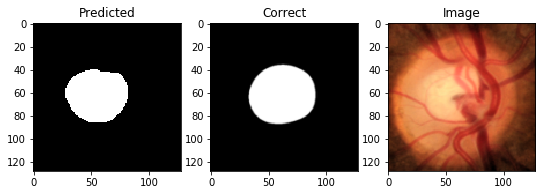

IOU: 0.704626321793
Dice: 0.836290840357
image #6


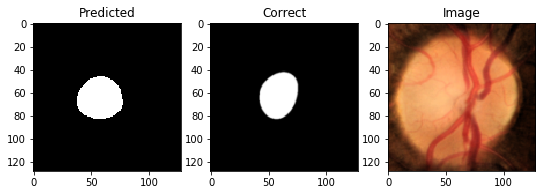

IOU: 0.742243409157
Dice: 0.864632199205
image #7


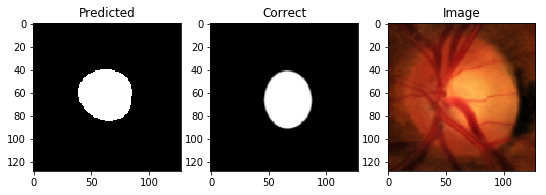

IOU: 0.711558878422
Dice: 0.841833652719
image #8


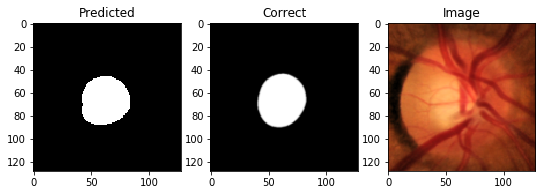

IOU: 0.904020726681
Dice: 0.961737900581
image #9


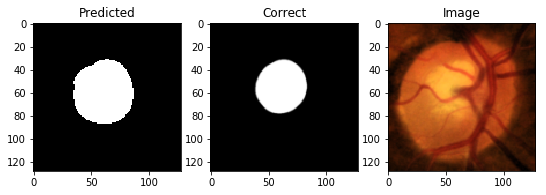

IOU: 0.682874381542
Dice: 0.820771857456
image #10


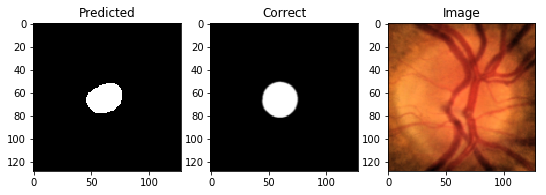

IOU: 0.7578125
Dice: 0.881062367947
image #11


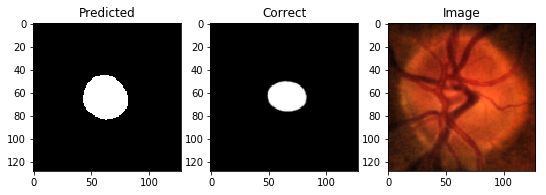

IOU: 0.564146161079
Dice: 0.73299229828
image #12


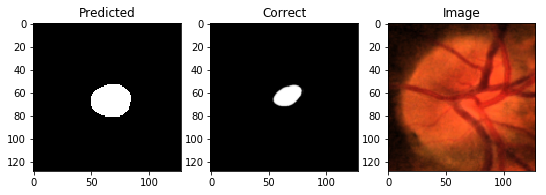

IOU: 0.400503784418
Dice: 0.580248476442
image #13


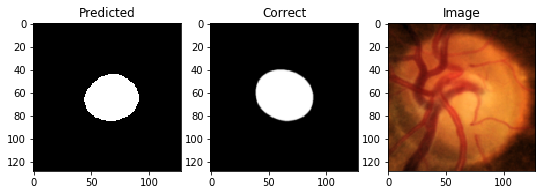

IOU: 0.790710687637
Dice: 0.891221349721
image #14


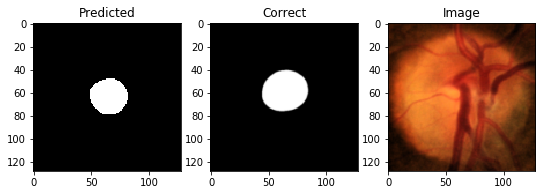

IOU: 0.62478774786
Dice: 0.783257911343
image #15


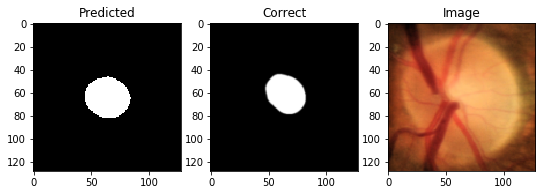

IOU: 0.738825619221
Dice: 0.862843487263
image #16


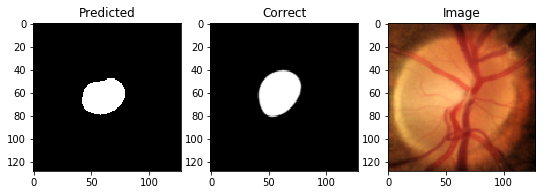

IOU: 0.716481626034
Dice: 0.848622498861
image #17


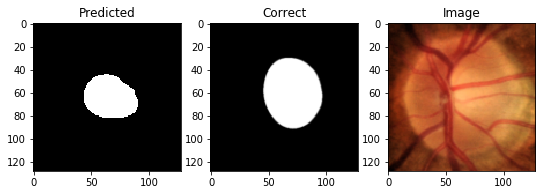

IOU: 0.537059545517
Dice: 0.707412660209
image #18


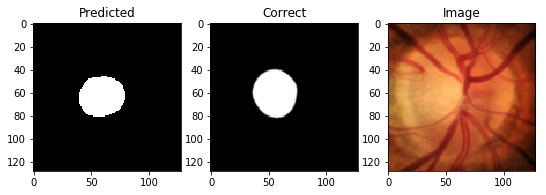

IOU: 0.741071403027
Dice: 0.86331818741
image #19


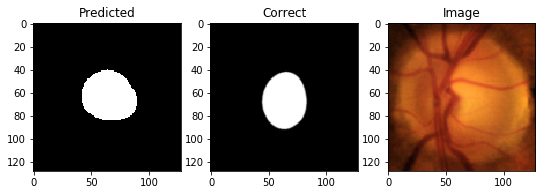

IOU: 0.707076251507
Dice: 0.838681977071
image #20


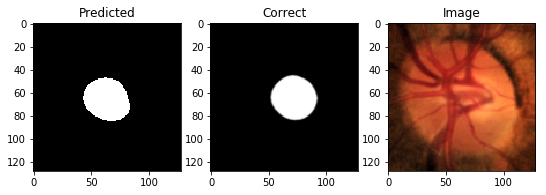

IOU: 0.550166130066
Dice: 0.72211772978
image #21


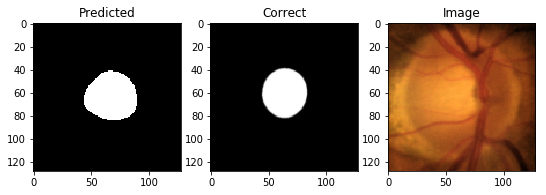

IOU: 0.736874639988
Dice: 0.861107663477
image #22


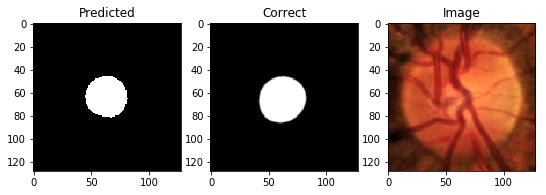

IOU: 0.792586743832
Dice: 0.895806707326
image #23


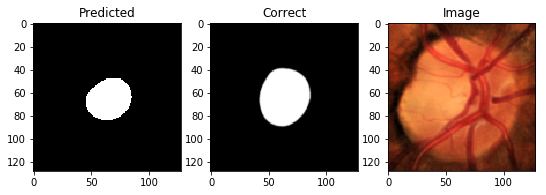

IOU: 0.65032106638
Dice: 0.802449592447
image #24


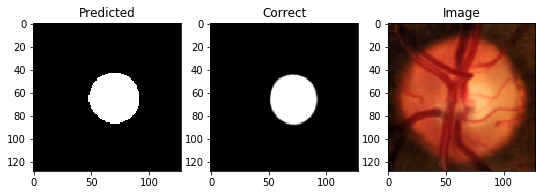

IOU: 0.867273926735
Dice: 0.937756289912
image #25


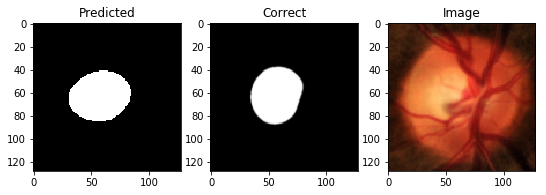

IOU: 0.805924415588
Dice: 0.9031888323
image #26


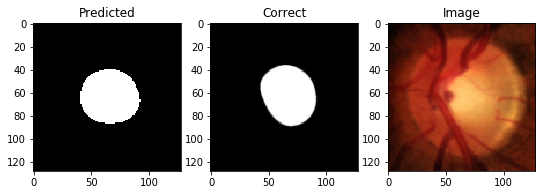

IOU: 0.837452471256
Dice: 0.922055835462
image #27


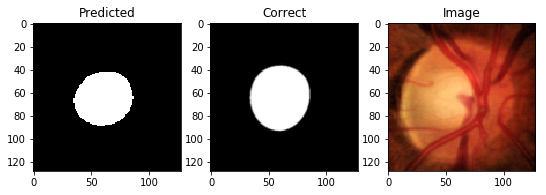

IOU: 0.823992967606
Dice: 0.913174314611
image #28


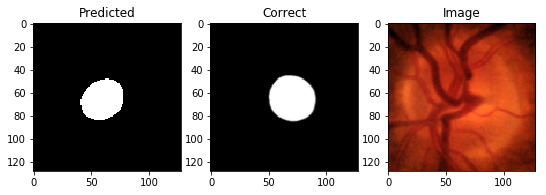

IOU: 0.465295642614
Dice: 0.647131728617
image #29


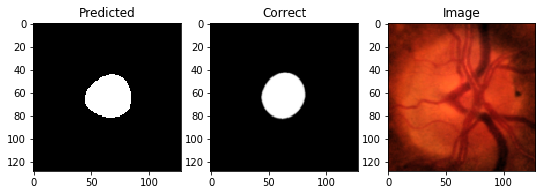

IOU: 0.826465904713
Dice: 0.916658868075
image #30


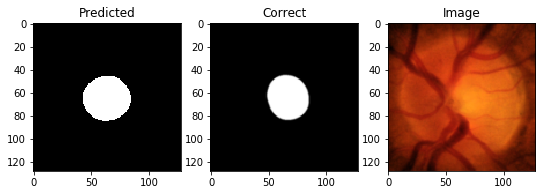

IOU: 0.78286999464
Dice: 0.891788443675
image #31


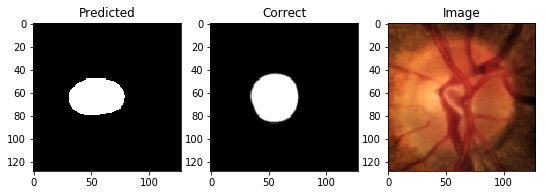

IOU: 0.738522946835
Dice: 0.862471200331


In [29]:
pred_iou, pred_dice = [], []

if K.backend() == 'tensorflow':
    sess = K.get_session()

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    if K.backend() == 'tensorflow':
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
    else:
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [119]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.7119856
0.8374559859471065


Showing the best and the worst cases:

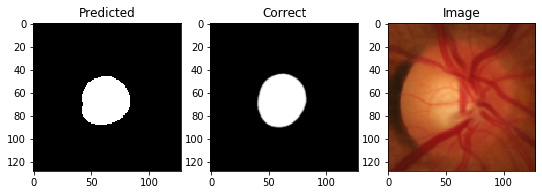

IOU: 0.9005201458930969, Dice: 0.9595170462735056 (best)


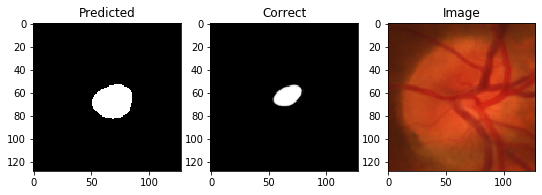

IOU: 0.3955223858356476, Dice: 0.5753085890097761 (worst)


In [120]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    idx = [img_no]
    batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
    # batch_X = [np.rollaxis(img, 2) for img in batch_X]
    batch_X = [skimage.transform.resize(img, (128, 128)) for img in batch_X]
    batch_X = np.array(batch_X).copy()
    img = batch_X[0]

    batch_y = [Y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
    batch_y = [img[..., 0] for img in batch_y]
    batch_y = [skimage.transform.resize(img, (128, 128))[..., None] for img in batch_y]
    batch_y = np.array(batch_y).copy()
    
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    plt.show()

best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {}, Dice: {} (best)'.format(pred_iou[best_idx], pred_dice[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {}, Dice: {} (worst)'.format(pred_iou[worst_idx], pred_dice[worst_idx]))

### Loading model

In [117]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recent file in a folder:
    model_folder = weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '01.03,10_33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss')
    
    #model_folder = weights_folder
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].idxmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].idxmax()])

Loading weights from /home/artem/Загрузки/optic-nerve-cnn/models_weights/01.03,10_33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5

max val mean IOU: 0.7148739546539999, at row:
epoch               245.000000
dice_metric           0.799437
loss                  0.163397
mean_IOU_gpu          0.675642
val_dice_metric       0.828447
val_loss              0.134474
val_mean_IOU_gpu      0.714874
Name: 245, dtype: float64

max val dice_metric: 0.828446704894, at row:
epoch               245.000000
dice_metric           0.799437
loss                  0.163397
mean_IOU_gpu          0.675642
val_dice_metric       0.828447
val_loss              0.134474
val_mean_IOU_gpu      0.714874
Name: 245, dtype: float64
